In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
feat_index = 0
includeFlipped = False

In [ ]:
feat_files = ['inception','mediapipe','vgg16']
feat_size = [2048,126,1000]

print(feat_files[feat_index], 'is being used')

data_file = '/content/drive/MyDrive/Colab Notebooks/SL_features/'+feat_files[feat_index]+'.csv'

converter={'Features': lambda x: np.fromstring(str(x).
                                               replace('[','').replace(']',''), 
                                               sep=',')[:feat_size[feat_index]]
           .reshape((feat_size[feat_index],1))}

mp_data = pd.read_csv(data_file, converters = converter)

mediapipe is being used


In [ ]:
mp_data.head(5)

,n,Filepath,Flipped,Model,Field_len,Features
0,1,\A\A1.jpg,0,1,126,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...."
1,2,\A\A1.jpg,1,1,126,"[[0.5083845257759094], [0.5018740892410278], [..."
2,3,\A\A2.jpg,0,1,126,"[[0.4831370711326599], [0.55935138463974], [-1..."
3,4,\A\A2.jpg,1,1,126,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...."
4,5,\A\A3.jpg,0,1,126,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...."


In [ ]:
letters = mp_data['Filepath'].str[:3].unique()
letters = list(map(lambda x: x.replace('\\',''),letters))
letters
ltr_dict = { k:v for v, k in enumerate(letters,1)}
ltr_dict
#alternative
#dict(zip(letters,range(len(letters))))

{'A': 1,
 'B': 2,
 'C': 3,
 'E': 4,
 'EE': 5,
 'F': 6,
 'GH': 7,
 'H': 8,
 'I': 9,
 'II': 10,
 'J': 11,
 'L': 12,
 'M': 13,
 'N': 14,
 'O': 15,
 'P': 16,
 'Q': 17,
 'R': 18,
 'S': 19,
 'SH': 20,
 'T': 21}

In [ ]:
feat_data = np.stack(mp_data.Features.to_numpy()) # without np.stack() it will be array of arrays, not 2d array
feat_mn = feat_data.min()
feat_mx = feat_data.max()
print('Min:',feat_mn,'Max:',feat_mx)

Min: -1.1980257034301758 Max: 1.180842399597168


In [ ]:
x = mp_data.loc[mp_data['Filepath'].str.startswith('\B') & (mp_data['Flipped']==0)]
x.head()

,n,Filepath,Flipped,Model,Field_len,Features
1484,1485,\B\B1.jpg,0,1,126,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...."
1486,1487,\B\B2.jpg,0,1,126,"[[0.46263423562049866], [0.8022677898406982], ..."
1488,1489,\B\B3.jpg,0,1,126,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...."
1490,1491,\B\B4.jpg,0,1,126,"[[0.428175687789917], [0.8183003664016724], [3..."
1492,1493,\B\B5.jpg,0,1,126,"[[0.6564767360687256], [0.73099285364151], [4...."


In [ ]:
# To calculate Fisher Score
#   n_j    - number of samples in class j
#   mu_i   - mean value of feature f_i
#   mu_ij  - mean value of feature f_i in class j
#   var_ij - variance of feature f_i for samples in class j

# 1. Keep only [class, features]                                                       \A\A from fname   \A\A -> AA    use ID instead
cls_feat_data = mp_data[mp_data['Flipped']==0][['Filepath','Features']].apply(lambda x: x.str[:3].str.replace('\\','').map(ltr_dict) if x.name=='Filepath' else x)
cls_feat_data.head(5)

# 2. Calculate all mu
feats = np.squeeze(np.stack(cls_feat_data['Features'].to_numpy()),axis=2)
mu_all = np.mean(feats,0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  


Outliers 5 : [3.23184352e+12 5.48489216e+02 3.24960546e+12 7.89020649e+02
 3.54986360e+02]


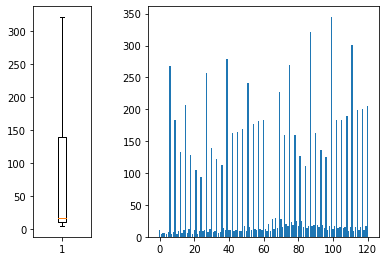

In [ ]:
# 3. Calculate mu and variance per class and formula
numer = np.zeros((feat_size[feat_index]),np.float32)
denom = np.zeros((feat_size[feat_index]),np.float32)

for v in ltr_dict.values():
  per_class = cls_feat_data[cls_feat_data['Filepath']==v]
  feats = np.squeeze(np.stack(per_class['Features'].to_numpy()),axis=2)
  feats = (feats - feat_mn) / (feat_mx-feat_mn)
  mu_i  = np.mean(feats,0)
  var_i = np.var(feats,0)
  n_j = feats.shape[0]
  
  numer = numer + n_j * np.power((mu_i - mu_all),2)
  denom = denom + n_j * var_i

Fisher_Score = numer/denom

# outliers are the ones outside the +3 sigma
outlier_idx = Fisher_Score> (np.mean(Fisher_Score)+3*np.std(Fisher_Score))
print('Outliers',np.sum(outlier_idx),':',Fisher_Score[outlier_idx])
figure, axis = plt.subplots(1, 2,gridspec_kw={'width_ratios': [1, 4]})

axis[0].boxplot(Fisher_Score,showfliers = False)
#axis[0].set_title(feat_files[feat_index]+" box & whisker")

# Draw only non-outliers
axis[1].bar(range(feat_size[feat_index]-np.sum(outlier_idx)),Fisher_Score[np.invert(outlier_idx)])
#axis[1].set_title(feat_files[feat_index]+" bar")

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

In [ ]:
# To calculate Feature Discernibility
all_vr = np.zeros((0,feat_size[feat_index]),np.float32)

# considering 21 letters only - for some reason mediapipe contains 21, inception 24 letters
for ltr in letters[:21]: 
  x = mp_data.loc[mp_data['Filepath'].str.startswith(ltr) & (includeFlipped or mp_data['Flipped']==0)].Features
  x = (x - feat_mn) / (feat_mx-feat_mn)
  vr = np.var(x.to_numpy(),0)
  vr = np.expand_dims(vr.flatten(), axis=0)
  all_vr = np.append(all_vr,vr,axis=0)

# If a 2D array, a boxplot is drawn for each column 
# showfliers - to show or hide outliers
plt.boxplot(all_vr.transpose(), showfliers = False); # ; is used to eliminate verbose

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)


ZeroDivisionError: ignored

In [ ]:
# To see the tolerance to the Flipped Images
# To calculate Feature Discernibility
all_vr = np.zeros((0,feat_size[feat_index]),np.float32)

# considering 21 letters only - for some reason mediapipe contains 21, inception 24 letters
for ltr in letters[:21]: 
  # flipped
  x_f = mp_data.loc[mp_data['Filepath'].str.startswith(ltr) & mp_data['Flipped']==1].sort_values('Filepath')
  # original - shall correspond to the flipped (not all originals have flipped versions)
  x_o = mp_data[(mp_data['Filepath'].isin(list(x_f.Filepath))) & (mp_data['Flipped']==0)].sort_values('Filepath')

  x = np.abs(x_o.Features.to_numpy() - x_f.Features.to_numpy())
  x = (x - feat_mn) / (feat_mx-feat_mn)
  vr = np.var(x,0)
  vr = np.expand_dims(vr.flatten(), axis=0)
  all_vr = np.append(all_vr,vr,axis=0)

# If a 2D array, a boxplot is drawn for each column 
# showfliers - to show or hide outliers
plt.boxplot(all_vr.transpose(), showfliers = False); # ; is used to eliminate verbose